# This program will use an artificial recurrent neural network (LSTM) to predict the closing stock price of a corporation (AAPL) using the past 60 day stock price.

### I completed this with help from the Computer Science YouTube channel
https://www.youtube.com/watch?v=QIUxPv5PJOY

In [682]:
# Importing libraries
import math 
import pandas as pd 
import numpy as np 
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM

In [683]:
df = web.DataReader(name = 'AAPL', data_source='yahoo',start = '2012-01-01', end = '2021-1-1')

In [684]:
df.shape, df.index

((2265, 6),
 DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
                '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
                '2012-01-13', '2012-01-17',
                ...
                '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
                '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
                '2020-12-30', '2020-12-31'],
               dtype='datetime64[ns]', name='Date', length=2265, freq=None))

In [685]:
# Seeing how many days the stock wasn't open for 

closed_days = 365 - (df.shape[0]%365)

In [686]:
print(f'The AAPL stock was not traded for {closed_days} days.')

The AAPL stock was not traded for 290 days.


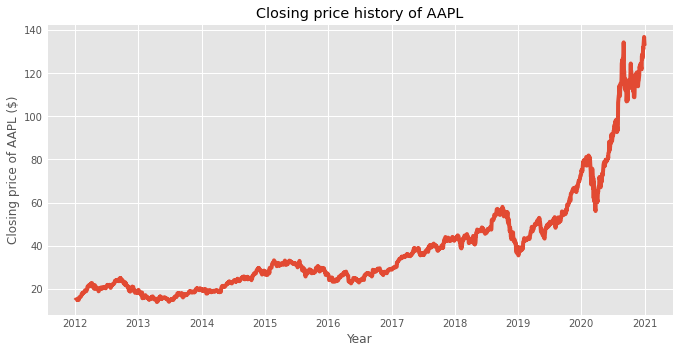

In [687]:
# Visualising the closing price history 

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (10,5))
ax.set(title = 'Closing price history of AAPL',
      xlabel = 'Year',
      ylabel = 'Closing price of AAPL ($)');

ax.plot(df['Close']);

## We can observe that the Apple stock price has increased from around 10 dollars a share in 2010 to almost 140 dollars in 2021.

In [688]:
# Create a new dataframe with only the close column 
df_close = df.filter(['Close'])

In [689]:
# Converting to numpy array 
dataset = df_close.values

# Get number of rows to train model on 
training_data_len = math.ceil(len(dataset)* .8)

## Machine learning models work better with scaled data

In [690]:
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))

In [691]:
scaled_data = scaler.fit_transform(dataset)

In [692]:
# Create training set / scaled training set 
train_data = scaled_data[:training_data_len,:]

# Splitting into x and y train 
X_train = []
y_train = []

for i in range(60, training_data_len):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

### So the cell above is concerned with splitting the scaled data into the 60 values before a date and the price on that date itself. This will be used to train the LSTM

In [693]:
# Convert the x and y training sets to numpy arrays so they will work with the model

X_train , y_train = np.array(X_train) , np.array(y_train)

In [694]:
# Reshape the data 
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

## Building the LSTM model

In [695]:
model = Sequential()
model.add(LSTM(50,
               return_sequences = True,
               input_shape = (X_train.shape[1],1)))

In [696]:
model.add(LSTM(50, return_sequences = False))

In [697]:
model.add(Dense(25))

In [698]:
model.add(Dense(1))

In [699]:
# Compiling the model
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [700]:
# Train the model 
model.fit(X_train,y_train, batch_size =1 , epochs = 1)

1752/1752 [==============================] - 30s 16ms/step - loss: 5.6042e-04


In [701]:
# Create test data set / scaled test data set 
test_data = scaled_data[training_data_len-60:,]

# Create x and y test scaled data sets
X_test = []
y_test = dataset[training_data_len:,]

We set y_test to be the set of closing stock values that weren't included in the training set. This way we can compare the values predicted by the model to the actual values in order to give an accuracy reading of the model.

In [702]:
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i,0])

In [703]:
# Converting X_test from a list to numpy array to make it compatible with the model

X_test = np.array(X_test)

In [704]:
# Reshape the data 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [705]:
# Get the models predicted price values
y_pred = model.predict(X_test)

We inversely transform the predicted values to take them from being scaled (for the model's benefit) to normal stock prices.

In [706]:
y_pred = scaler.inverse_transform(y_pred)

## Evaluating the model 

In [707]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(y_pred - y_test)**2)

In [708]:
print(f'The value the model predicts compared to the actual value is off by {rmse.round(10)*100}% on average. ')

The value the model predicts compared to the actual value is off by 103.54014854% on average. 


## Plot the data

In [709]:
train = df_close[:training_data_len]
valid = df_close[training_data_len:]

valid['Predictions'] = y_pred

<ipython-input-709-6656cf2dd1e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


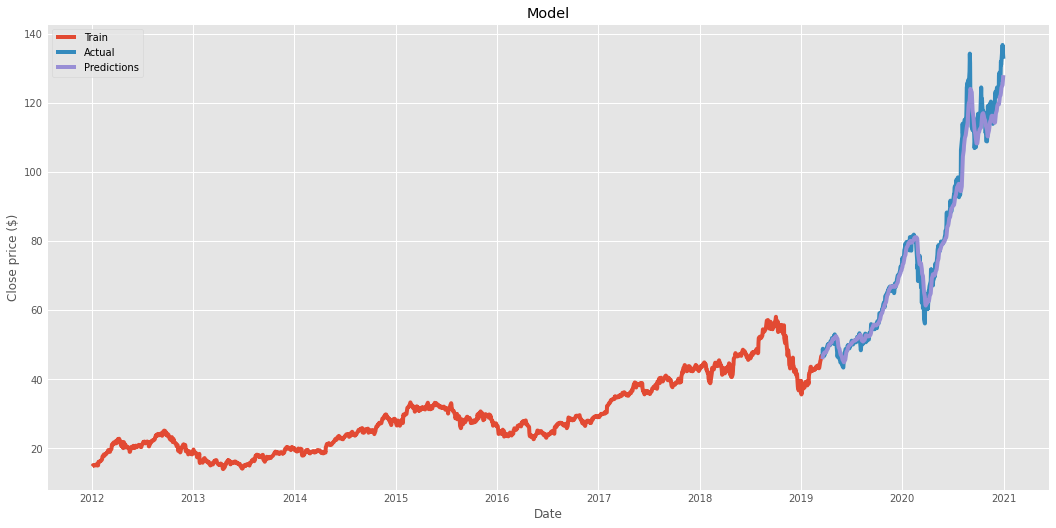

In [710]:
# Visualise the data 

plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close price ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Actual','Predictions'],loc = 'upper left')

In [711]:
# Show the actual vs predicted price 
valid

,Close,Predictions
Date,,
2019-03-19,46.632500,45.770580
2019-03-20,47.040001,46.149082
2019-03-21,48.772499,46.493965
2019-03-22,47.762501,46.977688
2019-03-25,47.185001,47.366707
...,...,...
2020-12-24,131.970001,124.338211
2020-12-28,136.690002,125.102341
2020-12-29,134.869995,126.269501


## Make a prediction for a date 

In [712]:
new_pred = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2021-01-01')

# Create new dataframe 
new_pred_df = new_pred.filter(['Close'])

# GEt last 60 day closing price values and covert the dataframe to an array
last_60_days = new_pred_df[-60:].values

# Scale data to be values between 0 and 1 
last_60_days_scaled = scaler.transform(last_60_days)

In [713]:
X_pred_test = []

X_pred_test.append(last_60_days_scaled)

X_pred_test = np.array(X_pred_test)

X_pred_test = np.reshape(X_pred_test, (X_pred_test.shape[0], X_pred_test.shape[1], 1))

new_pred = model.predict(X_pred_test)

In [714]:
new_pred = scaler.inverse_transform(new_pred)
new_pred

array([[128.29231]], dtype=float32)

In [723]:
new_pred2 = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2021-01-01')
new_pred2['Close']

Date
2012-01-03     14.686786
2012-01-04     14.765714
2012-01-05     14.929643
2012-01-06     15.085714
2012-01-09     15.061786
                 ...    
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
2020-12-30    133.720001
2020-12-31    132.690002
Name: Close, Length: 2265, dtype: float64

### The predicted value on 2020-12-31 is 4 dollars less than the actual value on the same date.